<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/TX_TimeSeriesLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab finds the possible 'New Cases' in some counties in Texas 

# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_alldatasets_Jan13.csv
 CA_CombinedData_Labeled_CDCGuideline_Jan15.csv
 CA_CovidDataJan10.csv
 CA_GoogleMobilityDataJan10.csv
 CA_MarylandData_Labeled_CDCGuideline_Jan15.csv
 CA_processedMarylandData_Jan11.csv
 CA_SocialDistancingDataJan10.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Jan10.csv
 NY_alldatasets_Jan13.csv
 NY_CombinedData_Labeled_CDCGuideline_Jan15.csv
 NY_CovidDataJan10.csv
 NY_GoogleMobilityDataJan10.csv
 NY_MarylandData_Labeled_CDCGuideline_Jan15.csv
 NY_processedMarylandData_Jan11.csv
 NY_SocialDistancingDataJan10.csv
'Policy_Map_(Sized)_Full_Data_data.csv'
 TX_alldatasets_Jan11.csv
 TX_CombinedData_Labeled_CDCGuideline_Jan15.csv
 TX_CovidDataJan10.csv
 TX_GoogleMobilityDataJan10.csv
 TX_MarylandData_Labeled_CDCGuideline_Jan15.csv
 TX_processedMarylandData_Jan11.csv
 TX_processedMarylandData_Jan11.gsheet
 TX_SocialDistancingDataJan10.cs

In [20]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import median_absolute_error, mean_absolute_error



# Load combined data for TX

In [5]:
TX_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/TX_alldatasets_Jan11.csv',low_memory=False)
TX_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,Texas,48001,0,Anderson County,57735,0,8.9100,79,16.0000,15.0000,0.0000,0.0000,3.0000,0.0000
1,2020-03-02,Texas,48001,0,Anderson County,57735,0,10.7080,95,14.0000,7.0000,0.0000,0.0000,2.0000,-1.0000
2,2020-03-03,Texas,48001,0,Anderson County,57735,0,12.1180,107,21.0000,8.0000,0.0000,0.0000,2.0000,-2.0000
3,2020-03-04,Texas,48001,0,Anderson County,57735,0,9.1560,81,12.0000,5.0000,0.0000,0.0000,1.0000,2.0000
4,2020-03-05,Texas,48001,0,Anderson County,57735,0,11.2300,100,18.0000,13.0000,0.0000,0.0000,3.0000,-3.0000


In [6]:
X_cols = [ 'mask_rule_active','m50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline','Date','New cases']

In [7]:
Harris_combined_data = TX_combined_data[TX_combined_data['County Name'] == 'Harris County'][X_cols]
print(Harris_combined_data.shape)
Harris_combined_data.head(5)

(300, 11)


,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Date,New cases
20931,0,6.3160,70,10.0000,5.0000,-8.0000,1.0000,3.0000,-1.0000,2020-03-01,0
20932,0,8.7170,97,9.0000,7.0000,11.0000,0.0000,4.0000,-2.0000,2020-03-02,0
20933,0,8.9480,100,13.0000,10.0000,27.0000,2.0000,3.0000,-2.0000,2020-03-03,0
20934,0,8.8370,98,8.0000,8.0000,1.0000,0.0000,2.0000,0.0000,2020-03-04,0
20935,0,9.6440,107,10.0000,9.0000,31.0000,3.0000,3.0000,-2.0000,2020-03-05,2


In [8]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
def datetime_to_float(d):
    date_time_obj = datetime.strptime(d, '%Y-%m-%d')
    return date_time_obj.timestamp()

In [9]:
len(Harris_combined_data.columns)

11

In [10]:
Harris_combined_data['Date'] = Harris_combined_data['Date'].apply(lambda x: datetime_to_float(x))
#Harris_combined_data.index.name = 'Date'
Harris_combined_data.head()

,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Date,New cases
20931,0,6.3160,70,10.0000,5.0000,-8.0000,1.0000,3.0000,-1.0000,1583020800.0000,0
20932,0,8.7170,97,9.0000,7.0000,11.0000,0.0000,4.0000,-2.0000,1583107200.0000,0
20933,0,8.9480,100,13.0000,10.0000,27.0000,2.0000,3.0000,-2.0000,1583193600.0000,0
20934,0,8.8370,98,8.0000,8.0000,1.0000,0.0000,2.0000,0.0000,1583280000.0000,0
20935,0,9.6440,107,10.0000,9.0000,31.0000,3.0000,3.0000,-2.0000,1583366400.0000,2


## Preprocessing data for LSTM

In [11]:
Harris_combined_data_selected = Harris_combined_data[X_cols]

In [12]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [14]:
len(X_cols)

11

In [15]:
values = Harris_combined_data.values
# integer encode direction
encoder = LabelEncoder()
values[:,10] = encoder.fit_transform(values[:,10])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var9(t)  var10(t)  var11(t)
1     0.0000     0.6081     0.6087  ...   0.0000    0.0032    0.0000
2     0.0000     0.8414     0.8435  ...   0.0000    0.0065    0.0000
3     0.0000     0.8638     0.8696  ...   0.0667    0.0097    0.0000
4     0.0000     0.8531     0.8522  ...   0.0000    0.0129    0.0078
5     0.0000     0.9315     0.9304  ...   0.0333    0.0161    0.0039

[5 rows x 22 columns]


## Train Test Split

In [16]:
values.shape[0]

300

In [17]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

236
values shape  (299, 22)
(236, 1, 21) (236,) (63, 1, 21) (63,)


# Training LSTM

Epoch 1/100
4/4 - 3s - loss: 0.3803 - val_loss: 0.5631
Epoch 2/100
4/4 - 0s - loss: 0.3115 - val_loss: 0.4585
Epoch 3/100
4/4 - 0s - loss: 0.2592 - val_loss: 0.3657
Epoch 4/100
4/4 - 0s - loss: 0.2304 - val_loss: 0.2908
Epoch 5/100
4/4 - 0s - loss: 0.2201 - val_loss: 0.2434
Epoch 6/100
4/4 - 0s - loss: 0.2177 - val_loss: 0.2238
Epoch 7/100
4/4 - 0s - loss: 0.2157 - val_loss: 0.2173
Epoch 8/100
4/4 - 0s - loss: 0.2122 - val_loss: 0.2184
Epoch 9/100
4/4 - 0s - loss: 0.2076 - val_loss: 0.2243
Epoch 10/100
4/4 - 0s - loss: 0.2027 - val_loss: 0.2323
Epoch 11/100
4/4 - 0s - loss: 0.1985 - val_loss: 0.2405
Epoch 12/100
4/4 - 0s - loss: 0.1946 - val_loss: 0.2469
Epoch 13/100
4/4 - 0s - loss: 0.1909 - val_loss: 0.2498
Epoch 14/100
4/4 - 0s - loss: 0.1869 - val_loss: 0.2480
Epoch 15/100
4/4 - 0s - loss: 0.1823 - val_loss: 0.2433
Epoch 16/100
4/4 - 0s - loss: 0.1780 - val_loss: 0.2385
Epoch 17/100
4/4 - 0s - loss: 0.1736 - val_loss: 0.2335
Epoch 18/100
4/4 - 0s - loss: 0.1695 - val_loss: 0.2288
E

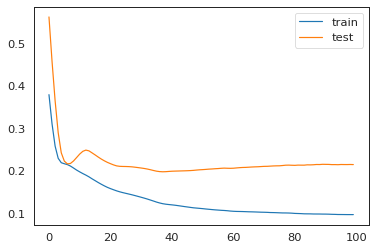

In [18]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Test

In [19]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(63, 21)
Test MSE: 0.074
Test RMSE: 0.271


In [21]:
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

median_absolute_error 0.19736958
mean_absolute_error 0.21570387


# Load Maryland inertia

In [23]:
TX_maryland_sd_inertia = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/TX_processedMarylandData_Jan11.csv',low_memory=False)
TX_maryland_sd_inertia.head(5)

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,48001,Anderson County,TX,57735,48001,Anderson County,48,45,24,2.5800,20.1000,0.4000,34.1000,0.3000,2.2800,0,58057,-22.8000,2020-01-01,0.2200,20,43355,21.0000,17.5000,61.2000,54,12,95,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,0.0000
1,48001,Anderson County,TX,57735,48001,Anderson County,48,16,16,3.3600,21.3000,0.3000,42.7000,0.5300,2.8200,0,58057,-4.5000,2020-01-02,0.2200,20,43355,21.0000,17.5000,61.2000,54,12,95,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,0.0000
2,48001,Anderson County,TX,57735,48001,Anderson County,48,10,13,3.6500,23.5000,0.5000,47.7000,0.5500,3.1000,0,58057,4.9000,2020-01-03,0.2200,20,43355,21.0000,17.5000,61.2000,54,12,95,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,0.0000
3,48001,Anderson County,TX,57735,48001,Anderson County,48,20,17,3.3300,25.5000,0.5000,46.2000,0.4000,2.9300,0,58057,-0.8000,2020-01-04,0.2200,20,43355,21.0000,17.5000,61.2000,54,12,95,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,0.0000
4,48001,Anderson County,TX,57735,48001,Anderson County,48,32,21,2.9300,21.4000,0.6000,42.7000,0.3600,2.5700,0,58057,-13.0000,2020-01-05,0.2200,20,43355,21.0000,17.5000,61.2000,54,12,95,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.7000,3.5000,4.6000,0.2000,0.0000


In [ ]:
maryland_sd_inertia.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

In [24]:
inertia_X_cols = ['Social.distancing.index', 'X..staying.home', 'Trips.person',
                  'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
                  'Work.trips.person', 'Non.work.trips.person','X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans','X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
       'Unemployment.rate', 'X..working.from.home',
       'Cumulative.inflation.rate', 'date','New.COVID.cases']

In [25]:
Harris_inertia_data = maryland_sd_inertia[maryland_sd_inertia['CTNAME'] == 'Harris County'][inertia_X_cols]
print(len(Harris_inertia_data.columns))
Harris_inertia_data.head()

38


,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,date,New.COVID.cases
36300,56,30,2.2000,16.0000,1.0000,27.3000,0.1900,2.0100,-26.3000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,2020-01-01,0
36301,26,20,2.9800,16.8000,0.7000,35.7000,0.5400,2.4400,-10.5000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,2020-01-02,0
36302,15,16,3.3500,16.8000,0.7000,38.8000,0.5600,2.7900,2.4000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,2020-01-03,0
36303,29,20,3.0400,16.4000,0.7000,34.8000,0.3000,2.7400,0.5000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,2020-01-04,0
36304,42,25,2.6200,16.1000,0.9000,31.8000,0.2300,2.3900,-12.3000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.7000,3.5000,4.6000,0.2000,2020-01-05,0


In [26]:
Harris_inertia_data['date'] = Harris_inertia_data['date'].apply(lambda x: datetime_to_float(x))
Harris_inertia_data.head()

,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,X..change.in.consumption,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,date,New.COVID.cases
36300,56,30,2.2000,16.0000,1.0000,27.3000,0.1900,2.0100,-26.3000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,1577836800.0000,0
36301,26,20,2.9800,16.8000,0.7000,35.7000,0.5400,2.4400,-10.5000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,1577923200.0000,0
36302,15,16,3.3500,16.8000,0.7000,38.8000,0.5600,2.7900,2.4000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,1578009600.0000,0
36303,29,20,3.0400,16.4000,0.7000,34.8000,0.3000,2.7400,0.5000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.4000,3.5000,4.6000,0.2000,1578096000.0000,0
36304,42,25,2.6200,16.1000,0.9000,31.8000,0.2300,2.3900,-12.3000,2.6000,15,60146,18.6000,42.6000,49.7200,2589,1219,138,2.8200,0.3000,0.0400,0.0000,0.0000,0,47.7000,0.0000,0.0000,0.0000,0,0,0.0000,0,0.7000,3.5000,4.6000,0.2000,1578182400.0000,0


# Preprocess Data

In [28]:
len(inertia_X_cols)

38

In [27]:
values = Harris_inertia_data.values
# integer encode direction
encoder = LabelEncoder()
values[:,37] = encoder.fit_transform(values[:,37])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var36(t)  var37(t)  var38(t)
1     0.7077     0.5517     0.1463  ...    0.7263    0.0028    0.0000
2     0.2462     0.2069     0.4634  ...    0.7263    0.0055    0.0000
3     0.0769     0.0690     0.6138  ...    0.7263    0.0083    0.0000
4     0.2923     0.2069     0.4878  ...    0.7263    0.0110    0.0000
5     0.4923     0.3793     0.3171  ...    0.7263    0.0138    0.0000

[5 rows x 76 columns]


# Train Test split

In [29]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

288
values shape  (362, 76)
(288, 1, 75) (288,) (74, 1, 75) (74,)


# Training LSTM for inertia data

Epoch 1/100
4/4 - 2s - loss: 0.2761 - val_loss: 0.4052
Epoch 2/100
4/4 - 0s - loss: 0.2058 - val_loss: 0.2730
Epoch 3/100
4/4 - 0s - loss: 0.1662 - val_loss: 0.1874
Epoch 4/100
4/4 - 0s - loss: 0.1523 - val_loss: 0.1622
Epoch 5/100
4/4 - 0s - loss: 0.1482 - val_loss: 0.1771
Epoch 6/100
4/4 - 0s - loss: 0.1443 - val_loss: 0.1891
Epoch 7/100
4/4 - 0s - loss: 0.1336 - val_loss: 0.1855
Epoch 8/100
4/4 - 0s - loss: 0.1203 - val_loss: 0.1768
Epoch 9/100
4/4 - 0s - loss: 0.1163 - val_loss: 0.1788
Epoch 10/100
4/4 - 0s - loss: 0.1155 - val_loss: 0.1932
Epoch 11/100
4/4 - 0s - loss: 0.1131 - val_loss: 0.2138
Epoch 12/100
4/4 - 0s - loss: 0.1100 - val_loss: 0.2343
Epoch 13/100
4/4 - 0s - loss: 0.1077 - val_loss: 0.2388
Epoch 14/100
4/4 - 0s - loss: 0.1053 - val_loss: 0.2252
Epoch 15/100
4/4 - 0s - loss: 0.1034 - val_loss: 0.2097
Epoch 16/100
4/4 - 0s - loss: 0.1022 - val_loss: 0.2025
Epoch 17/100
4/4 - 0s - loss: 0.1007 - val_loss: 0.2013
Epoch 18/100
4/4 - 0s - loss: 0.0990 - val_loss: 0.2009
E

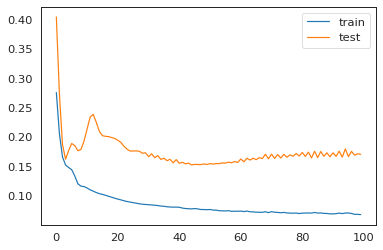

In [30]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Testing LSTM for inertia data

In [31]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

(74, 75)
Test MSE: 0.046
Test RMSE: 0.215
median_absolute_error 0.15317354
mean_absolute_error 0.17071252
